In [1]:
# Complete Speech Emotion Recognition Pipeline (Single Cell)
# No per‐epoch prints of loss/accuracy — training runs silently.

# 0. Setup & Imports
import os
import warnings
import timeit
import multiprocessing as mp
import numpy as np
import pandas as pd
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from joblib import Parallel, delayed
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
)

warnings.simplefilter("ignore")
print("CPUs available:", mp.cpu_count())

2025-05-06 09:12:10.745617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746522730.948557      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746522730.997533      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CPUs available: 4


In [2]:
# 1. Paths to audio datasets
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
crema_path  = "/kaggle/input/cremad/AudioWAV/"
tess_path   = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
savee_path  = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"


In [3]:
# 2. Load & parse each dataset
def load_dataset(base_path, parser):
    records = []
    for entry in os.listdir(base_path):
        records.extend(parser(base_path, entry))
    return pd.DataFrame(records)

def parse_ravdess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        code = fname.split('-')[2]
        label = {
            '01':'neutral','02':'calm','03':'happy','04':'sad',
            '05':'angry','06':'fearful','07':'disgust','08':'surprised'
        }[code].lower()
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

ravdess_df = load_dataset(ravdess_path, parse_ravdess)

def parse_crema(base, fname):
    lab = fname.split('_')[2]
    label = {'SAD':'sad','ANG':'angry','DIS':'disgust',
             'FEA':'fearful','HAP':'happy','NEU':'neutral'}.get(lab, 'unknown').lower()
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

crema_df = load_dataset(crema_path, parse_crema)

def parse_tess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        lab = fname.split('_')[2].lower()
        label = 'surprised' if lab=='ps' else lab
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

tess_df = load_dataset(tess_path, parse_tess)

def parse_savee(base, fname):
    ele = fname.split('_')[1][:-6]
    label = {'a':'angry','d':'disgust','f':'fearful',
             'h':'happy','n':'neutral','sa':'sad'}.get(ele, 'surprised')
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

savee_df = load_dataset(savee_path, parse_savee)

Total samples: 12162


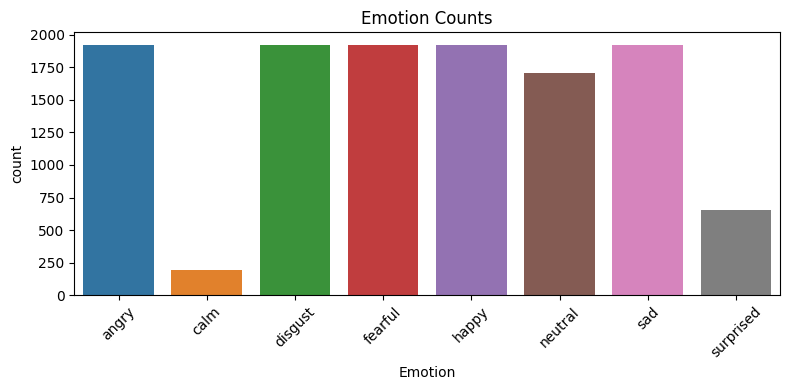

In [4]:
# 3. Combine, clean & inspect
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
data_path['Emotion'] = data_path['Emotion'].str.replace(r"\.wav$", "", regex=True)
data_path['Emotion'] = data_path['Emotion'].replace({
    'fear':'fearful','ps':'surprised','pleasantsurprise':'surprised'
})
data_path = shuffle(data_path, random_state=42).reset_index(drop=True)

print("Total samples:", len(data_path))
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=data_path, order=sorted(data_path.Emotion.unique()))
plt.title("Emotion Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# 4. Augmentation functions
def add_noise(x): return x + 0.035*np.random.uniform()*np.amax(x)*np.random.normal(size=x.shape)
def stretch(x, rate=0.8): return librosa.effects.time_stretch(y=x, rate=rate)
def shift(x): return np.roll(x, int(np.random.uniform(-5,5)*1000))
def pitch(x, sr, n_steps=0.7): return librosa.effects.pitch_shift(y=x, sr=sr, n_steps=n_steps)


In [6]:
# 5. Fixed-length feature extractor
n_mfcc, max_frames = 40, 100
def pad_truncate(feat, max_len):
    return (np.pad(feat, ((0,0),(0,max_len-feat.shape[1])), mode='constant')
            if feat.shape[1]<max_len else feat[:,:max_len])

def extract_features_fixed(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = pad_truncate(mfcc, max_frames)
    mfcc = (mfcc - mfcc.mean())/(mfcc.std()+1e-6)
    z = pad_truncate(librosa.feature.zero_crossing_rate(y=y), max_frames)
    r = pad_truncate(librosa.feature.rms(y=y), max_frames)
    stacked = np.vstack((mfcc, z, r))
    return stacked.flatten()

def get_features(path):
    y, sr = librosa.load(path, duration=2.5, offset=0.6)
    out = [extract_features_fixed(y, sr)]
    for fn in (add_noise, lambda x: stretch(x,0.8), shift, lambda x: pitch(x, sr, 0.7)):
        out.append(extract_features_fixed(fn(y), sr))
    return np.stack(out, axis=0)

In [7]:
# 6. Parallel feature computation
start = timeit.default_timer()
results = Parallel(n_jobs=-1)(delayed(get_features)(p) for p in data_path.Path)
print("Feature extraction time:", timeit.default_timer() - start)

Feature extraction time: 656.436476271


In [8]:
# 7. Assemble X, Y
X, Y = [], []
for feats, emo in zip(results, data_path.Emotion):
    for vec in feats:
        X.append(vec)
        Y.append(emo)
X = np.vstack(X)
Y = np.array(Y)
print("Feature array shape:", X.shape)

Feature array shape: (60810, 4200)


In [9]:
# 8. Preprocess & split
scaler = StandardScaler().fit(X); X_scaled = scaler.transform(X)
encoder = OneHotEncoder(sparse=False).fit(Y.reshape(-1,1))
Y_enc = encoder.transform(Y.reshape(-1,1))

x_tr, x_te, y_tr, y_te = train_test_split(
    X_scaled, Y_enc, test_size=0.2, random_state=42, stratify=Y
)
x_tr_cnn = x_tr[..., np.newaxis]
x_te_cnn = x_te[..., np.newaxis]
print("Train/Test shapes:", x_tr_cnn.shape, x_te_cnn.shape)

Train/Test shapes: (48648, 4200, 1) (12162, 4200, 1)


In [10]:
from tensorflow.keras.callbacks import Callback

# 9. Epoch-detail logger callback
class EpochDetailLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        l = logs or {}
        print(f"Epoch {epoch+1} -> loss: {l['loss']:.4f}, acc: {l['accuracy']:.4f}, "
              f"val_loss: {l['val_loss']:.4f}, val_acc: {l['val_accuracy']:.4f}")


In [11]:
# 10. Model & train
from tensorflow.keras.callbacks import Callback


model = Sequential([
    Conv1D(512, 5, padding='same', activation='relu', input_shape=x_tr_cnn.shape[1:]),
    BatchNormalization(), MaxPooling1D(5, 2, padding='same'),
    
    Conv1D(512, 5, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'), Dropout(0.2),
    
    Conv1D(256, 5, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'),
    
    Conv1D(256, 3, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'), Dropout(0.2),
    
    Conv1D(128, 3, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(3, 2, padding='same'), Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'), BatchNormalization(),
    Dense(Y_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3),
    EpochDetailLogger()
]

# Train
history = model.fit(
    x_tr_cnn, y_tr,
    validation_data=(x_te_cnn, y_te),
    epochs=50, batch_size=64,
    callbacks=callbacks,
    verbose=0
)

I0000 00:00:1746523405.208942      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1746523414.996660     122 service.cc:148] XLA service 0x7ce92401e100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746523414.997256     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746523415.622882     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746523428.449519     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 -> loss: 1.0497, acc: 0.6112, val_loss: 0.8511, val_acc: 0.6813
Epoch 2 -> loss: 0.7408, acc: 0.7259, val_loss: 0.7294, val_acc: 0.7303
Epoch 3 -> loss: 0.5403, acc: 0.7999, val_loss: 0.8024, val_acc: 0.7148
Epoch 4 -> loss: 0.4269, acc: 0.8430, val_loss: 0.6007, val_acc: 0.7883
Epoch 5 -> loss: 0.3023, acc: 0.8922, val_loss: 0.4532, val_acc: 0.8393
Epoch 6 -> loss: 0.2049, acc: 0.9274, val_loss: 0.4166, val_acc: 0.8563
Epoch 7 -> loss: 0.1451, acc: 0.9485, val_loss: 0.4816, val_acc: 0.8416
Epoch 8 -> loss: 0.0999, acc: 0.9665, val_loss: 0.4530, val_acc: 0.8595
Epoch 9 -> loss: 0.0878, acc: 0.9702, val_loss: 0.4232, val_acc: 0.8723
Epoch 10 -> loss: 0.0971, acc: 0.9667, val_loss: 0.5125, val_acc: 0.8424
Epoch 11 -> loss: 0.1126, acc: 0.9612, val_loss: 0.3822, val_acc: 0.8846
Epoch 12 -> loss: 0.0491, acc: 0.9844, val_loss: 0.3711, val_acc: 0.8926
Epoch 13 -> loss: 0.0633, acc: 0.9784, val_loss: 0.6122, val_acc: 0.8407
Epoch 14 -> loss: 0.0695, acc: 0.9754, val_loss: 0.4116, val

In [12]:
# 11. Save training history for later visualization
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)



Train Accuracy:      0.9999
Validation Accuracy: 0.9240

Confusion Matrix:
[[1815    0   35   15   39   13    4    2]
 [   0  189    2    0    0    1    0    0]
 [  26    0 1766   25   18   27   61    0]
 [  15    1   35 1724   43   23   79    3]
 [  45    0   28   28 1765   36   14    7]
 [   4    2   22   13   17 1603   42    0]
 [   5    1   54   57   16   52 1738    0]
 [   1    0    3    4    4    1    1  638]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.95      0.94      0.95      1923
        calm       0.98      0.98      0.98       192
     disgust       0.91      0.92      0.91      1923
     fearful       0.92      0.90      0.91      1923
       happy       0.93      0.92      0.92      1923
     neutral       0.91      0.94      0.93      1703
         sad       0.90      0.90      0.90      1923
   surprised       0.98      0.98      0.98       652

    accuracy                           0.92     12162
   macro avg 

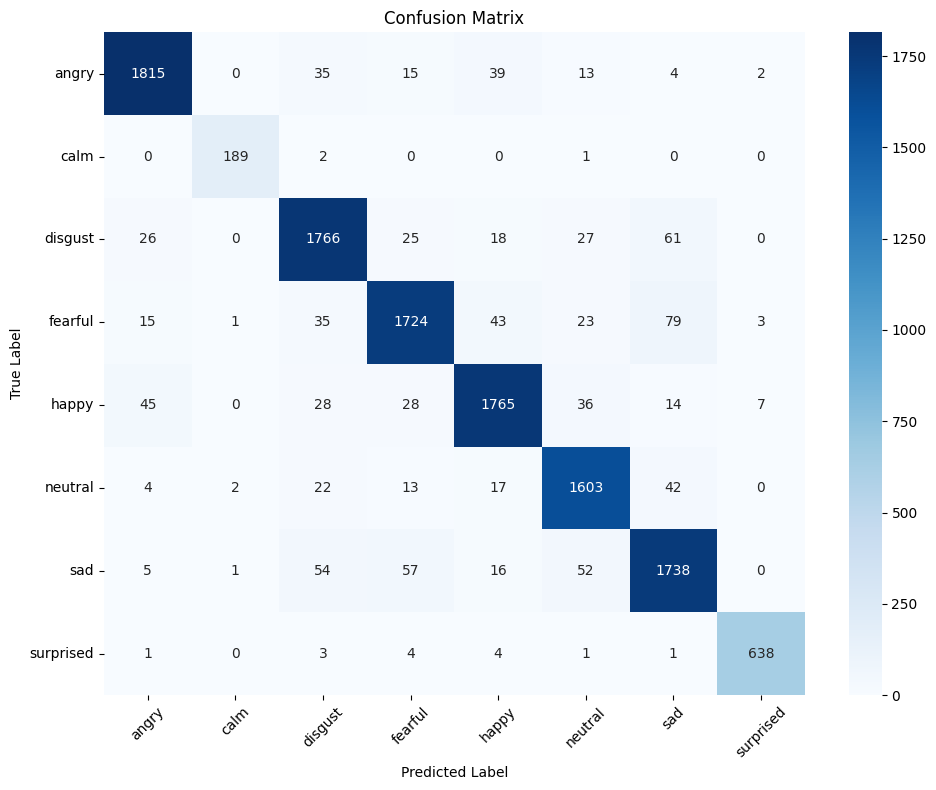

In [13]:
# 12. Evaluate & report
train_loss, train_acc = model.evaluate(x_tr_cnn, y_tr, verbose=0)
val_loss, val_acc     = model.evaluate(x_te_cnn, y_te, verbose=0)
print(f"\nTrain Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

y_pred_probs = model.predict(x_te_cnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_te, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = encoder.categories_[0]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

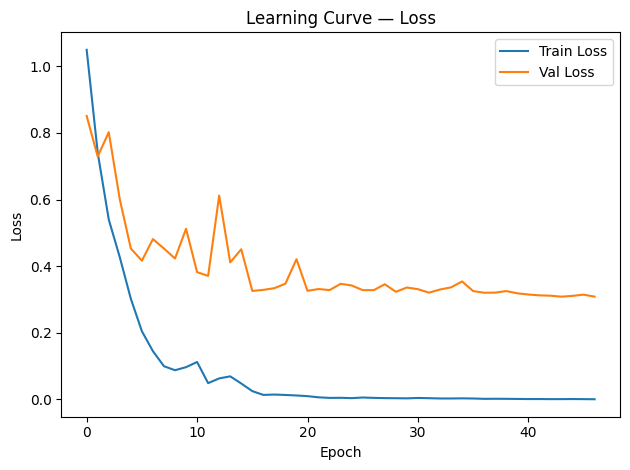

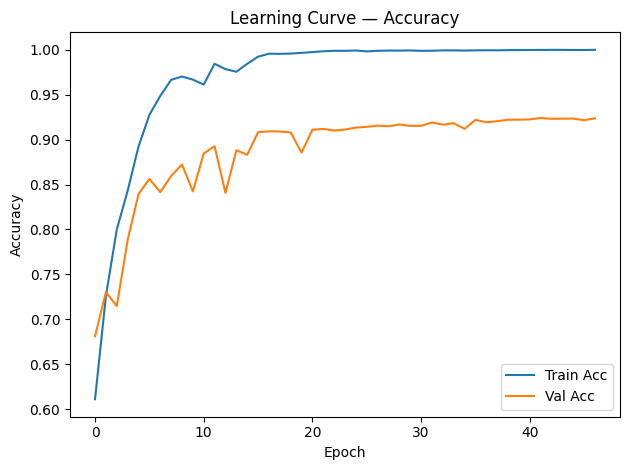

In [14]:
# 13. Load best model & history to visualize learning curves (any time!)
best_model = load_model('best_model.keras')
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

# Plot Loss
plt.figure()
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve — Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(hist['accuracy'], label='Train Acc')
plt.plot(hist['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve — Accuracy')
plt.legend()
plt.tight_layout()
plt.show()